#                                  FordGoBike Ride Sharing in San Francisco

## Executive Summary:

This report is a data driven analysis of the San Francisco bike sharing company (FordGoBike, now owned by Lyft) for the sole objective of increasing the bike ridership in the bay area. The target audience of this report is the executive leadership of FordGoBike/Lyft interested in understanding the bike ridership and customer behavior. The report uses two publicly available big datasets provided on Google cloud: san_francisco, which is a static dataset and san_francisco_bikeshare, which is a dynamic dataset updated every 15 minutes. Although the motivation for the report is academic in nature, one could mine important business and productivity implications to the ever growing traffic in the bay area. The report makes an attempt to address two important questions around the most popular commuter trips as well as recommendations for offers/deals through the mobile app to increase ridership. Based on the analysis of data, the report also provides a few interesting customer insights and then makes appropriate recommendations based on a rigorous, analytical methodology that a business consultant would apply. Our recommendation based on the below analysis is to introduce two types of passes: "Weekend pass" and "Family pass" because the bikers in this segment seem to be participating much less compared with the other segments.

## Introduction:

Volume ridership of customers is driven by the product, price, place and promotion (commonly referred in the business world as the 4Ps framework). 

Let's think about the first P, product, for a moment. There are a few products (services in this context) provided by the bikeshare company: Single ride, monthly membership, annual membership, corporate membership, bulk passes and access passes. We have data classifed into two product categories: subscriber and customer. Subscriber type could be an annual or 30 day member. Customer could be a 24 hour or 3 day member. We focus our analysis on these two types to understand their growth rates year over year. The intuition is that we want to understand which type is growing faster organically and focus on that type. Furthermore, we also want to understand which type is slower and why. 

The next aspect in the 4P model is the price. We do not have much information about price in the dataset but a little research on the web suggests that pricing is extremely favourable to encourage ridership. If more data and time were available, one could evaluate price elasticity to understand the incremental impact on ridership due to further reduction in price. We assume that in general pricing is at its lowest ($15/month, $149/year) although we make a recommendation on price for a particular customer segment based on an insight.

The third aspect in the 4P model is the place (sales channels such as mobile, web and physical station). Clearly, our focus is on mobile because people are on the move anyway and are used to ordering cabs on the go. Unfortunately, we do not have data around mobile channel sales in the Google public dataset. Therefore, we only make educated guesses in terms of mobile penetration, customer conversion rate etc. 

Last but not the least is the 4th P, promotion (sales) of the ride sharing services. We do not have data about promotional aspects of the bike ridership but again make some reasonable, plausible recommendations on how to increase ridership using promotional activities.

Based on the the above framework, we performed some data analysis and came up with the following insights: 1. The subscriber segment is significantly higher and growing faster at ~40% YoY on average than the customer segment (~25% YoY on average). 2. Weekday trips were 6 times higher than weekend trips in San Francisco, which means that ridership is primary used for commuting unlike, for example, in a different location such as Seattle, where bike ridership is primarily used for leisure activities (evidence out of scope for this exercise). 3. There is a heavy gender skew towards male bike riders compared with female riders. There are some other potential insights that we are not sharing in this report due to lack of complete availability of evidence.

Based on the above insights, we recommend the following: 

1. Because bike business is a predominantly fixed costs (very expensive land, bike SG&A, IT infrastructure etc), we want to maximize ridership to full utilization at all times. Therefore, we recommend demand based pricing to optimize for 100% utilization. Currently, the utilization of bikes, especially over the weekends is very low.  Given that SFO is a popular tourist location, we recommend that the company price it appropriately (low) for the "customer" segment to maximize utilization over the weekend for tourist activities.

2. Focus heavily on the female customer segment. This requires the company to strategically position the product for the female market by understanding the SFO female activities better. If there is a heavier presence of women near care centers or shopping centers in SFO, one could have more bike stands in those locations. There could also be special promotional deals particularly for women. The idea at the end of the day is to increase female ridership. Further data from outside sources needs to be gathered to understand gender behavior

3. During weekday off-peak hours, focus on increasing the "customer" rides by targetted advertising and deals such as first five rides free, miles based discounts etc., so that customers are riding bikes in heavier numbers during off peak hours. Eventually, the recommendation is to agressively target the customers to convert customers into subscribers by providing them free first month rides etc.

Below are some sql queries, pandas and visualizations that were used to answer the two main questions (5 most popular trips and recommendations for ridership) and to generate other customer behavioral insights.


### Introduction

In [72]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


In [6]:
! bq query -q --use_legacy_sql=FALSE --max_rows=10000000 'SELECT trip_id, start_station_name, end_station_name, count(trip_id) as trip_freq FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY trip_id, start_station_name, end_station_name ORDER BY trip_freq DESC' > results.csv

In [7]:
print('\n\n\t\t\tExploratory data analysis')

#Get the size of the data set
! bq query -q --use_legacy_sql=FALSE  'SELECT COUNT(*) as DataSetSize FROM  `bigquery-public-data.san_francisco.bikeshare_trips`'

print('\n\nData Availability')
#Get the minimum start date and maximum end date
! bq query -q --use_legacy_sql=FALSE 'SELECT min(start_date) as MinStartDate, max(end_date) as MaxEndDate FROM `bigquery-public-data.san_francisco.bikeshare_trips`'

print('\n\n Bike Count')
#Get the total number of bikes
! bq query -q --use_legacy_sql=FALSE 'SELECT count(distinct bike_number) as NumberOfBikes FROM `bigquery-public-data.san_francisco.bikeshare_trips`'

print('\n\n Number of Stations')
#Get the total number of stations
! bq query -q --use_legacy_sql=FALSE 'SELECT count(distinct station_id) as StationCount FROM `bigquery-public-data.san_francisco.bikeshare_status`'



			Exploratory data analysis
+-------------+
| DataSetSize |
+-------------+
|      983648 |
+-------------+


Data Availability
+---------------------+---------------------+
|    MinStartDate     |     MaxEndDate      |
+---------------------+---------------------+
| 2013-08-29 09:08:00 | 2016-08-31 23:48:00 |
+---------------------+---------------------+


 Bike Count
+---------------+
| NumberOfBikes |
+---------------+
|           700 |
+---------------+


 Number of Stations
+--------------+
| StationCount |
+--------------+
|           75 |
+--------------+


In [81]:
#Commuter trip defined as any trip less than an hour between 6 AM - 10 AM and 3 PM - 7 PM on a weekday

#Top 5 popular commuter trips in 2018 selected based on the total number of unique trips between 
#"peak hours" of 6 AM - 10 AM and 3 PM - 7 PM in 2018 for less than 1 hour between any two bike stations

print('\n\t\t\t\t\t\tTop 5 Popular Commuter Trips\n')
print('The below table shows the five most popular trips less than 1 hour during peak hours between two stations in 2018.')
print('\n')

! bq query -q --use_legacy_sql=FALSE 'select start_station_name, end_station_name, count(*) as tripcount from `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` where (EXTRACT(YEAR FROM start_date) = 2018) and ( (EXTRACT(HOUR FROM start_date) > 6 and EXTRACT(HOUR FROM start_date) < 10) or  (EXTRACT(HOUR FROM start_date) > 15 and EXTRACT(HOUR FROM start_date) < 19) ) and   TIMESTAMP_DIFF(start_date, end_date, MINUTE) < 60  group by start_station_id, start_station_name, end_station_id, end_station_name order by tripcount desc limit 5' 




						Top 5 Popular Commuter Trips

The below table shows the five most popular trips less than 1 hour during peak hours between two stations in 2018.


+----------------------------------------------------+----------------------------------------------------+-----------+
|                 start_station_name                 |                  end_station_name                  | tripcount |
+----------------------------------------------------+----------------------------------------------------+-----------+
| San Francisco Ferry Building (Harry Bridges Plaza) | The Embarcadero at Sansome St                      |      1272 |
| The Embarcadero at Sansome St                      | Steuart St at Market St                            |      1017 |
| Berry St at 4th St                                 | San Francisco Ferry Building (Harry Bridges Plaza) |      1004 |
| San Francisco Ferry Building (Harry Bridges Plaza) | Berry St at 4th St                                 |       852 |
| Gran

### Customer Segment Analysis
The below tables make use realize that the two segments - Subscribers and Customers are on a different trajectory. Subscribers are many times higher than customers and continue to grow at a faster trajectory, at about ~200% year over year on average between 2013 and 2017. In the same time, customers have been growing at 17% between 2013 and 2017 on average. Clearly, it makes sense to continue to invest in the subscribers segment to grow the base even more while at the same time identify opportunities to grow the customer base. There could be many levers to do so including price manipulation and promotions.

In [52]:
# Question 1. What is the breakdown of subscribers vs customer trip counts each year? 

#Count taken at the end of the 35th week and Tuesday for any year (labor day issue and maximum availability of data considered, given that minimum start date is around that time)
! bq query -q --format=csv --use_legacy_sql=FALSE 'select subscriber_type, date(start_date) as trip_date, count(*) as day_trip_count from `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` where  ( (Extract(week from start_date) = 35 and Extract(dayofweek from start_date) = 3) ) and ( (Extract(hour from start_date) > 6 and Extract(hour from start_date) < 10) or (Extract(hour from start_date) > 15 and Extract(hour from start_date) < 19)) group by subscriber_type, trip_date order by  day_trip_count desc, trip_date desc' > SegmentGrowth.csv

#The above query is broken down into two other queries below - one for "subscribers" and the other for "customers"
! bq query -q --format=csv --use_legacy_sql=FALSE 'select subscriber_type, Extract(year from start_date) as trip_year, count(*) as subscriber_trip_count from `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` where  (subscriber_type = "Subscriber" and (Extract(week from start_date) = 35 and Extract(dayofweek from start_date) = 3) ) and ( (Extract(hour from start_date) > 6 and Extract(hour from start_date) < 10) or (Extract(hour from start_date) > 15 and Extract(hour from start_date) < 19)) group by subscriber_type, trip_year order by trip_year desc' > SegmentGrowth_Subscriber.csv
! bq query -q --format=csv --use_legacy_sql=FALSE 'select subscriber_type, Extract(year from start_date) as trip_year, count(*) as customer_trip_count from `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` where  (subscriber_type = "Customer" and (Extract(week from start_date) = 35 and Extract(dayofweek from start_date) = 3) ) and ( (Extract(hour from start_date) > 6 and Extract(hour from start_date) < 10) or (Extract(hour from start_date) > 15 and Extract(hour from start_date) < 19)) group by subscriber_type, trip_year order by trip_year desc' > SegmentGrowth_Customer.csv

In [53]:
# Question 2. How are the two segments growing year over year?

print('\n\t\t   Subscriber Growth\n')
subscriber_growth = pd.read_csv('SegmentGrowth_Subscriber.csv')
print(subscriber_growth)

print('\n\n\t\t   Customer Growth\n')
customer_growth = pd.read_csv('SegmentGrowth_Customer.csv')
print(customer_growth)



		   Subscriber Growth

  subscriber_type  trip_year  subscriber_trip_count
0      Subscriber       2017                   1820
1      Subscriber       2016                    853
2      Subscriber       2015                    891
3      Subscriber       2014                    847
4      Subscriber       2013                    159


		   Customer Growth

  subscriber_type  trip_year  customer_trip_count
0        Customer       2017                  221
1        Customer       2016                   26
2        Customer       2015                   39
3        Customer       2014                   49
4        Customer       2013                  117



The below chart shows that the subscriber segment is taking off compared with the customer segment


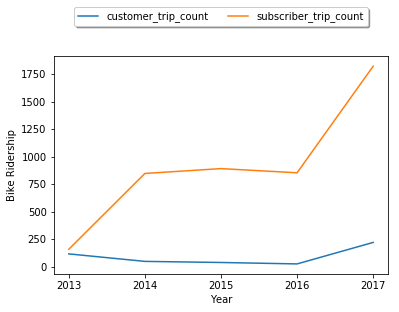

In [83]:
print('\nThe below chart shows that the subscriber segment is taking off compared with the customer segment')
line_chart1 = plt.plot(customer_growth['trip_year'], customer_growth['customer_trip_count'])
line_chart2 = plt.plot(subscriber_growth['trip_year'], subscriber_growth['subscriber_trip_count'])
plt.xticks(np.arange(min(customer_growth['trip_year']), max(customer_growth['trip_year'])+1, 1.0))
plt.xlabel('Year')
plt.ylabel('Bike Ridership', multialignment='center')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), shadow=True, ncol=2)
plt.show()

### Gender Analysis: 
From the below tables, we can see that male riders are three times the size of female riders in both 2017 and 2018. We will assume the same would have been the case in the years past due to the lack of data (NULL values).

In [25]:
# Question 3. Are males and females equally likely to ride the bikeshare? 
! bq query -q --format=csv --use_legacy_sql=FALSE 'select member_gender, count(*) as  trip_count, EXTRACT(YEAR FROM start_date) as year from `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` group by member_gender, year' > gender.csv

In [85]:
segment_gender = pd.read_csv("gender.csv")
print('There is a significantly higher number of males than females riding bikeshares in 2017 and 2018')
print('\n\t Riders by Gender\n  ')
print(segment_gender)


There is a significantly higher number of males than females riding bikeshares in 2017 and 2018

	 Riders by Gender
  
   member_gender  trip_count  year
0           Male      303453  2018
1            NaN       34196  2018
2         Female      100581  2018
3          Other        5841  2018
4         Female       98621  2017
5           Male      348318  2017
6            NaN       66462  2017
7          Other        6299  2017
8            NaN      346252  2015
9            NaN      326339  2014
10           NaN      210494  2016
11           NaN      100563  2013


### Weekday vs Weekend Trip Analysis:
From the below two tables, we see that SFO primarily uses bikes for non-leisure purposes. Its usage of bikes on weekdays is 4-5 times as much its usage of bikes on weekends. It also means that bikes are lying unused over the weekend. It is a great opportunity to apply demand based pricing to keep the utilization of bikes high during the weekends. For this, a fair amount of marketing efforts and online deals will need to complement each other.

In [60]:
# Question 4. Are bikes used for business (weekdays) or leisure (weekends) in general? 

#The below query checks for weekend trips each year
! bq query -q --format=csv --use_legacy_sql=FALSE 'select EXTRACT(YEAR FROM start_date) as year, count(*) as weekend_trips  from `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` where Extract(DAYOFWEEK FROM start_date) = 1 or Extract(DAYOFWEEK FROM start_date) = 7 group by year order by year desc' > weekend_trips.csv

In [61]:
weekend_trips = pd.read_csv("weekend_trips.csv")
print('\n\t All Weekend Riders By Year\n  ')
print(weekend_trips)


	 All Weekend Riders By Year
  
   year  weekend_trips
0  2018          77602
1  2017          96265
2  2016          19359
3  2015          34209
4  2014          40309
5  2013          17777


In [62]:
#The below query checks for weekday trips each year

! bq query -q --format=csv --use_legacy_sql=FALSE 'select EXTRACT(YEAR FROM start_date) as year, count(*) as weekday_trips  from `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` where Extract(DAYOFWEEK FROM start_date) != 1 and Extract(DAYOFWEEK FROM start_date) != 7 group by year order by year desc' > weekday_trips.csv

In [63]:
weekday_trips = pd.read_csv("weekday_trips.csv")
print('\n\t All Weekday Riders By Year\n')
print(weekday_trips)


	 All Weekday Riders By Year

   year  weekday_trips
0  2018         366469
1  2017         423435
2  2016         191135
3  2015         312043
4  2014         286030
5  2013          82786


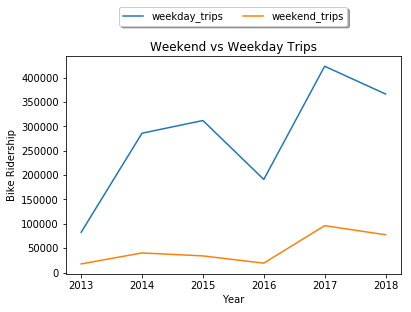

In [70]:
line_chart1 = plt.plot(weekday_trips['year'], weekday_trips['weekday_trips'])
line_chart2 = plt.plot(weekend_trips['year'], weekend_trips['weekend_trips'])
plt.xticks(np.arange(min(weekend_trips['year']), max(weekend_trips['year'])+1, 1.0))
plt.title('Weekend vs Weekday Trips')
plt.xlabel('Year')
plt.ylabel('Bike Ridership', multialignment='center')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), shadow=True, ncol=2)
plt.show()

### Conclusion:

In short, we conclude that there are opportunities to grow female riders and weekend customers. Our recommendation is to add a new "Family Pass" and "Weekend Pass", where bikes can be used by the family to take short trips or even long hikes during weekends. These passes serve in two ways. First, these passes will (hopefully) bring more women to ride bikes. The passes will also leverage excess capacity of bikes during the weekend and grow the "customer" type of segment. 

If we could perform further analysis, we should ponder some questions. For example: 1. At what rate is the bikeshare industry growing in general and SFO in particular? 2. At what rate are our competitors growing? 3. At what rate are alternative modes of rideshare and public transportation growing? 4. What is our market share compared to other modes of transportation? 5. Can this company launch in other first and second tier cities with the same strategy? Doing so will help our objective of increasing ridership even further. 